In [1]:
!uv add numpy matplotlib scikit-learn pandas torch torchvision

Resolved 105 packages in 16ms
Audited 74 packages in 30ms


## Downloading data

In [2]:
from torchvision import transforms
from torchvision.transforms import Compose, RandomResizedCrop, ColorJitter, RandomGrayscale, GaussianBlur, RandomSolarize, ToTensor

class DINOTransform:
    def __init__(self, num_local_views=6, global_crop_size=224, local_crop_size=96):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        self.global_t1 = transforms.Compose([
            transforms.RandomResizedCrop(global_crop_size, scale=(0.4, 1.0)),
            flip_and_color_jitter,
            GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            normalize,
        ])

        self.global_t2 = transforms.Compose([
            transforms.RandomResizedCrop(global_crop_size, scale=(0.4, 1.0)),
            flip_and_color_jitter,
            GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            RandomSolarize(threshold=128, p=0.2),
            normalize,
        ])

        self.num_local_views = num_local_views
        self.local_transform = transforms.Compose([
            transforms.RandomResizedCrop(local_crop_size, scale=(0.05, 0.4)),
            flip_and_color_jitter,
            GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            normalize,
        ])

    def __call__(self, img):
        views = []
        views.append(self.global_t1(img))
        views.append(self.global_t2(img))
        for _ in range(self.num_local_views):
            views.append(self.local_transform(img))
        return views


In [3]:
from torchvision import transforms
import torchvision
batch_size = 32
transform = transforms.Compose([transforms.ToTensor()])
# dataset_CIFAR100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataset_CIFAR100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=DINOTransform(
    num_local_views=6,
    global_crop_size=32,
    local_crop_size=14
))
print(f"Number of training samples: {len(dataset_CIFAR100)}")

Number of training samples: 50000


In [4]:
from torchvision import transforms
import torchvision
batch_size = 32
transform = transforms.Compose([transforms.ToTensor()])
# dataset_CIFAR100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataset_Imagenette = torchvision.datasets.Imagenette(root='./data', download=True, transform=DINOTransform(
    num_local_views=6,
    global_crop_size=224,
    local_crop_size=96
))
print(f"Number of training samples: {len(dataset_Imagenette)}")

Number of training samples: 9469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7380952..1.3584211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8081232..0.74193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5356624..0.14762534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6680672..-0.26843056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.0713727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.083654

8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.6988237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4157891..1.9428324].


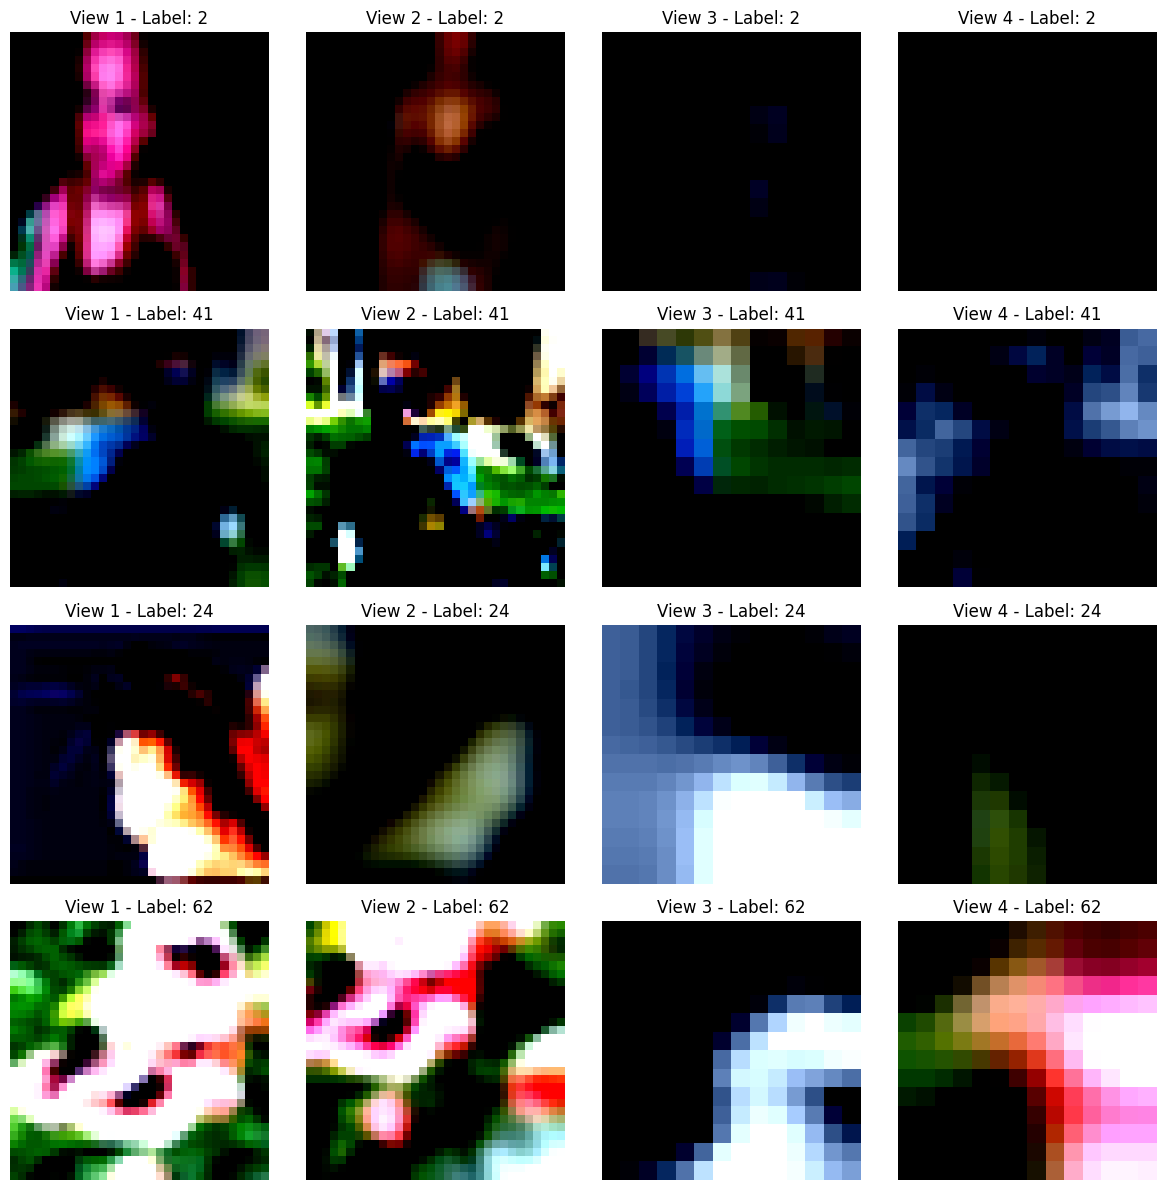

In [5]:
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_size = int(0.7 * len(dataset_CIFAR100) )  
valid_size = int(0.15 * len(dataset_CIFAR100) )
test_size = len(dataset_CIFAR100) - train_size - valid_size

train_CIFAR100, valid_CIFAR100, test_CIFAR100 = random_split(dataset=dataset_CIFAR100, lengths=[train_size, valid_size, test_size])

trainloader_CIFAR100 = DataLoader(train_CIFAR100, batch_size=batch_size, shuffle=True)
validloader_CIFAR100 = DataLoader(valid_CIFAR100, batch_size=batch_size, shuffle=False)
testloader_CIFAR100  = DataLoader(test_CIFAR100, batch_size=batch_size, shuffle=False)


views_set_CIFAR100, labels_CIFAR100 = next(iter(trainloader_CIFAR100))


print(len(views_set_CIFAR100))
range_image = 4
range_view = 8
#Plot the first 4 images of the first 4 views
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for v in range(4):
        axs[i, v].imshow(views_set_CIFAR100[v][i].permute(1, 2, 0))  # permute to HWC for imshow
        axs[i, v].set_title(f"View {v+1} - Label: {labels_CIFAR100[i].item()}")
        axs[i, v].axis('off')

plt.tight_layout()
plt.show()

torch.Size([32, 3, 96, 96])


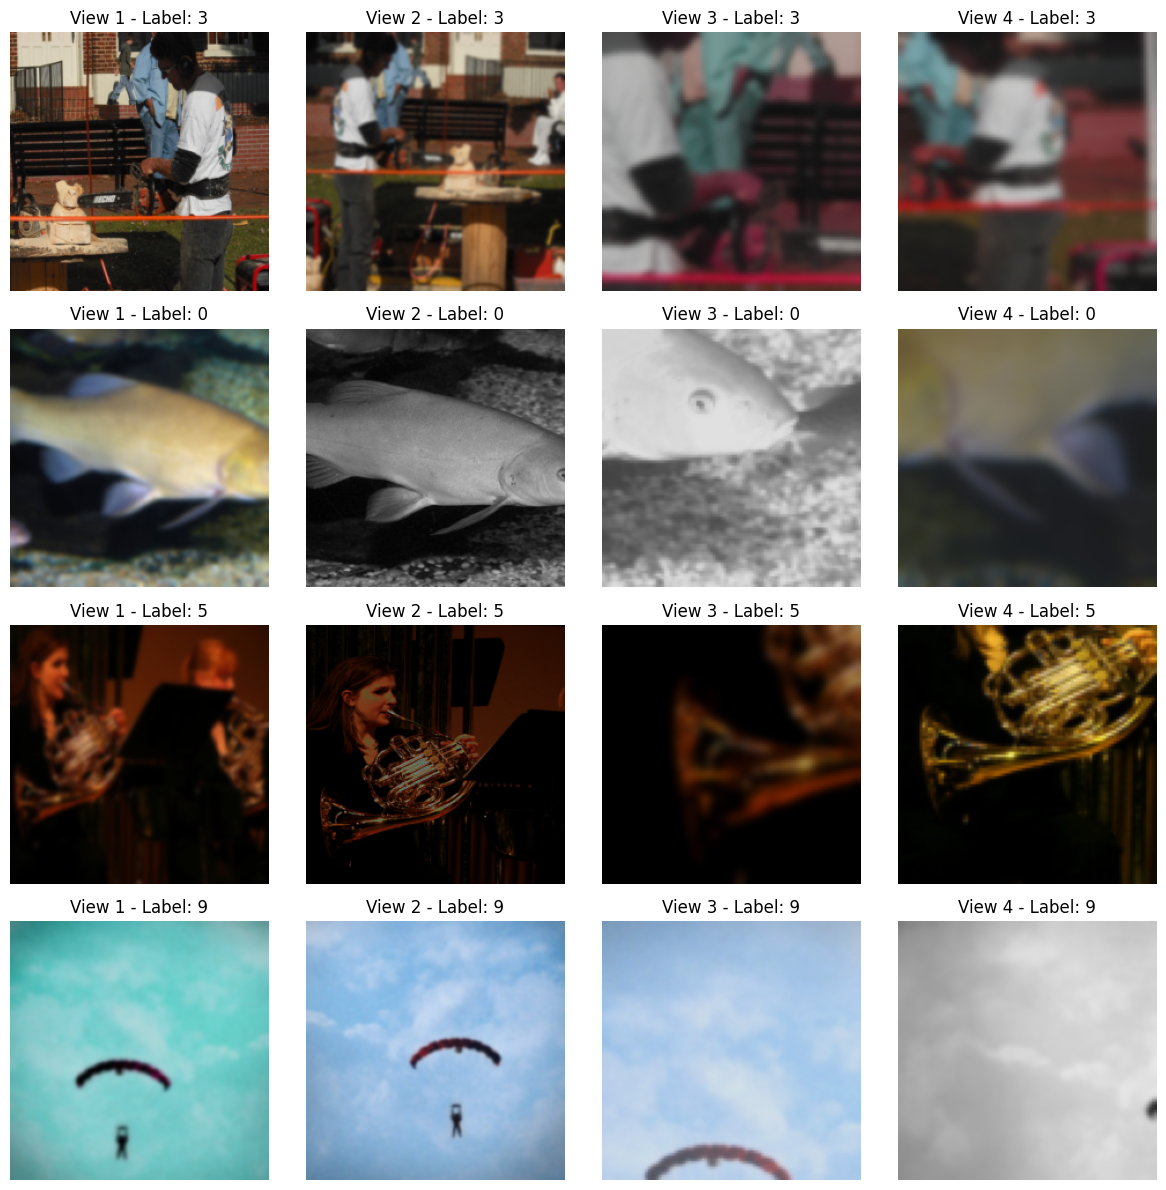

In [8]:
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch

train_size = int(0.7 * len(dataset_Imagenette) )  
valid_size = int(0.15 * len(dataset_Imagenette) )
test_size = len(dataset_Imagenette) - train_size - valid_size

train_Imagenette, valid_Imagenette, test_Imagenette = random_split(dataset=dataset_Imagenette, lengths=[train_size, valid_size, test_size])
trainloader_Imagenette = DataLoader(train_Imagenette, batch_size=batch_size, shuffle=True)
validloader_Imagenette = DataLoader(valid_Imagenette, batch_size=batch_size, shuffle=False)
testloader_Imagenette  = DataLoader(test_Imagenette, batch_size=batch_size, shuffle=False)

views_set_Imagenette, labels_Imagenette = next(iter(trainloader_Imagenette))

num_views = len(views_set_Imagenette)
batch_size_effective = labels_Imagenette.size(0)


IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    # img: [3, H, W] normalisée
    return img * IMAGENET_STD + IMAGENET_MEAN

range_images = min(4, batch_size_effective)
range_views = min(4, num_views)
#Plot the first 4 images of the first 4 views

global_views, local_views = get_global_locals(views_set_Imagenette)
print(local_views[3].shape)

fig, axs = plt.subplots(range_images, range_views, figsize=(12, 12))

for i in range(range_images):        # images
    for v in range(range_views):     # vues
        img = views_set_Imagenette[v][i]          # [3, H, W]
        img = denormalize(img).clamp(0.0, 1.0)    # retour en [0,1] pour imshow

        axs[i, v].imshow(img.permute(1, 2, 0).cpu().numpy())
        axs[i, v].set_title(f"View {v+1} - Label: {labels_Imagenette[i].item()}")
        axs[i, v].axis('off')

plt.tight_layout()
plt.show()

## Backbone

In [26]:
from torchvision import models
import torch.nn as nn


class ResnetBackboneDino(nn.Module):
    def __init__(self):
        super(ResnetBackboneDino, self).__init__()
        
        model = models.resnet18(weights=None)
        self.output_dim = model.fc.in_features
        # Remove the final fully connected layer
        model.fc = nn.Identity()
        self.model = model

    def forward(self, x):
        return self.model(x)
    
    def get_output_dim(self):
        return self.model.fc.in_features

'''
Default parameters from DINO paper 
 - Input dim = output of backbone
 - Output dim = 65536
 - Hidden dim = 2048
 - Bottleneck dim = 256
'''

class CovNetProjectionHeadDino(nn.Module):
    def __init__(self, input_dim=512, output_dim=2048, hidden_dim=1024, bottleneck_dim=256):
        super(CovNetProjectionHeadDino, self).__init__()
        self.output_dim = output_dim
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.last_layer = torch.nn.utils.parametrizations.weight_norm(nn.Linear(bottleneck_dim, output_dim, bias=False))

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

## EMA

In [27]:
class DinoModel(nn.Module):
    def __init__(self, backbone, projection_head):
        super(DinoModel, self).__init__()
        self.backbone = backbone
        self.projection_head = projection_head
        self.output_dim = projection_head.output_dim

    def forward(self, x, return_backbone_features = False):
        features = self.backbone(x)
        projections = self.projection_head(features)
        if return_backbone_features: 
            return features, projections
        return projections

In [39]:
from torch.optim import AdamW

backbone_student = ResnetBackboneDino()
projection_head_student = CovNetProjectionHeadDino(input_dim=backbone_student.output_dim)

covnetStudent = DinoModel(backbone_student, projection_head_student)

backbone_teacher = ResnetBackboneDino()
projection_head_teacher = CovNetProjectionHeadDino(input_dim=backbone_teacher.output_dim)

covnetTeacher = DinoModel(backbone_teacher, projection_head_teacher)


covnetTeacher.load_state_dict(covnetStudent.state_dict())

#Disable gradients for the teacher model
for p in covnetTeacher.parameters():
    p.requires_grad = False


lr = 0.001
opt = AdamW(covnetStudent.parameters(), lr=lr)

In [29]:
import torch
@torch.no_grad()
def update_teacher_EMA(student, teacher, alpha=0.99):
    for student_param, teacher_param in zip(student.parameters(), teacher.parameters()):
        teacher_param.data = alpha * teacher_param.data + (1 - alpha) * student_param.data

def get_global_locals(view_set):
    global_views = view_set[:2]
    local_views = view_set
    return global_views, local_views



In [30]:
import torch.distributed as dist

class DinoLoss(nn.Module):
    def __init__(self, out_dim, student_temp=0.1, teacher_temp=0.04, center_momentum=0.9, n_global_crops=2, ncrops=8):
        super(DinoLoss, self).__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.n_global_crops = n_global_crops
        self.ncrops = ncrops
        self.center_momentum = center_momentum

        # Register a buffer to store the center for teacher output normalization
        self.register_buffer("center", torch.zeros(1, out_dim))



    def forward(self, student_outputs, teacher_outputs):
        
        student_logits = student_outputs / self.student_temp
        student_log_probs = nn.functional.log_softmax(student_logits, dim=-1)
        student_log_probs = student_log_probs.chunk(self.ncrops)

        teacher_logits = (teacher_outputs - self.center) / self.teacher_temp
        teacher_probs = nn.functional.softmax(teacher_logits, dim=-1)
        #Prevent gradients flow through teacher
        teacher_probs = teacher_probs.detach()

        teacher_probs = teacher_probs.chunk(self.n_global_crops)

        total_loss = 0.0
        n_loss_terms = 0
        for i, teacher_output in enumerate(teacher_outputs):
            for j, student_output in enumerate(student_outputs):
                if i == j:
                    continue
                loss = -torch.sum(teacher_output * student_output, dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        
        total_loss /= n_loss_terms
        self.update_center(teacher_outputs)
        return total_loss
    
    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        teacher_output: [n_global_crops * B, C] raw logits
        Single process version - just batch mean.
        """
        batch_center = teacher_output.mean(dim=0, keepdim=True)  # [1, C]
        # EMA update
        self.center = self.center * self.center_momentum + \
                      batch_center * (1.0 - self.center_momentum)


In [42]:
def train_one_epoch(student, teacher, dataloader, dinoLoss):
    history = []
    student.train()
    teacher.eval()
    for it, (view_set, _) in enumerate(dataloader):
        print(f"Iteration {it+1}/{len(dataloader)}")
        global_views, views = get_global_locals(view_set)
        teacher_outputs = [teacher(v) for v in global_views]
        student_outputs = [student(v) for v in views]
        
        #Teacher output is size 2 with elements of shape [batch_size, output_dim]
        #Student output is size num_views with elements of shape [batch_size, output_dim]
        teacher_output = torch.cat(teacher_outputs, dim=0)   # [n_global_crops * B, C]
        student_output = torch.cat(student_outputs, dim=0)   # [ncrops * B, C]


        loss = dinoLoss(student_output, teacher_output)

        #MAJ des paramètres du student
        opt.zero_grad()
        loss.backward()
        opt.step()

        #Update teacher with EMA
        update_teacher_EMA(student, teacher, alpha=0.99)
        history.append(loss.item())
        print(loss.item())

    return history
        



In [43]:
dinoLoss = DinoLoss(out_dim=covnetStudent.output_dim, n_global_crops=2, ncrops=len(views_set_Imagenette))

thistory = train_one_epoch(covnetStudent, covnetTeacher, trainloader_Imagenette, dinoLoss)

Iteration 1/208
-1.7091362476348877
Iteration 2/208
-2.785752296447754
Iteration 3/208
-3.970656394958496
Iteration 4/208
-4.824885368347168
Iteration 5/208
-5.562676429748535
Iteration 6/208
-6.358214378356934
Iteration 7/208
-7.1023759841918945
Iteration 8/208
-7.7903571128845215
Iteration 9/208
-8.636222839355469
Iteration 10/208
-9.476673126220703
Iteration 11/208
-10.539511680603027
Iteration 12/208
-11.692906379699707
Iteration 13/208
-12.971135139465332
Iteration 14/208
-14.416831970214844
Iteration 15/208
-16.088560104370117
Iteration 16/208
-17.841075897216797
Iteration 17/208
-19.739215850830078
Iteration 18/208
-21.8279972076416
Iteration 19/208
-23.95556640625
Iteration 20/208
-26.364948272705078
Iteration 21/208
-28.808128356933594
Iteration 22/208
-31.473474502563477
Iteration 23/208
-34.285640716552734
Iteration 24/208
-37.22586441040039
Iteration 25/208
-40.37095260620117
Iteration 26/208
-43.69071578979492
Iteration 27/208
-47.14292907714844
Iteration 28/208
-50.805492

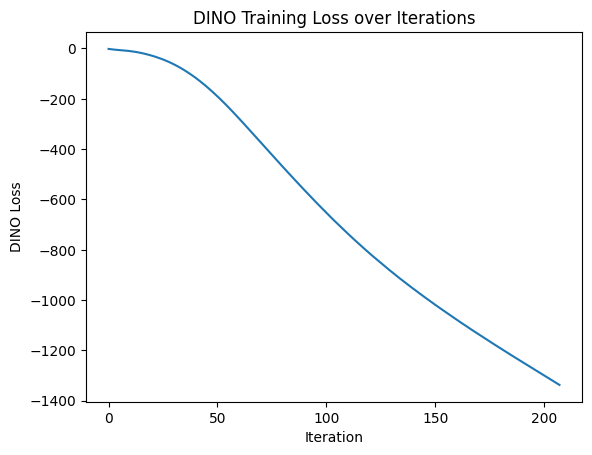

In [44]:
#plot history
import matplotlib.pyplot as plt
plt.plot(thistory)
plt.xlabel('Iteration')
plt.ylabel('DINO Loss')
plt.title('DINO Training Loss over Iterations')
plt.show()